In [3]:
from __future__ import division

import os, sys, time

import numpy as np
import scipy.linalg as sl, scipy.stats, scipy.special
import matplotlib.pyplot as plt
import libstempo as t2

from enterprise.pulsar import Pulsar
import enterprise.constants as const
from enterprise.signals import parameter
from enterprise.signals import utils
from enterprise.signals import prior
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from corner import corner

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
class Gibbs(object):
    def __init__(self, pta, model='gaussian', tdf=4):
        
        self.pta = pta
        
        # For now assume one pulsar
        self._residuals = self.pta.get_residuals()[0]
        
        # which likelihood model
        self._lmodel = model
        
        # auxiliary variable stuff
        self._b = np.zeros(self.pta.get_basis()[0].shape[1])
        
        
        # outlier stuff
        self._z = np.zeros_like(self._residuals)
        self._alpha = np.ones_like(self._residuals)
        self._theta = np.ones_like(self._residuals) * 0.01
        self.tdf = tdf
        if model in ['t', 'mixture']:
            self._z = np.ones_like(self._residuals)        
        
    @property
    def params(self):
        ret = []
        for param in self.pta.params:
            ret.append(param)
        return ret
    
    def map_params(self, xs):
        return {par.name: x for par, x in zip(self.params, xs)}
    
    
    def get_hyper_param_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'ecorr' in par.name or 'log10_A' in par.name or 'gamma' in par.name:
                ind.append(ct)
        return np.array(ind)  
    
    
    def get_white_noise_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'efac' in par.name or 'equad' in par.name:
                ind.append(ct)
        return np.array(ind)  
    
    
    def update_hyper_params(self, xs):
        
        # get hyper parameter indices
        hind = self.get_hyper_param_indices()
        
        # get initial log-likelihood and log-prior
        lnlike0, lnprior0 = self.get_lnlikelihood(xs), self.get_lnprior(xs)
        xnew = xs.copy()
        for ii in range(10):
    
            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(hind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(hind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0) 
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew

        return xnew
        
        
    def update_white_params(self, xs):
        
        # get white noise parameter indices
        wind = self.get_white_noise_indices()
        
        xnew = xs.copy()
        lnlike0, lnprior0 = self.get_lnlikelihood_white(xnew), self.get_lnprior(xnew)
        for ii in range(20):
        
            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(wind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(wind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood_white(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0) 
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew
        return xnew
        
    def update_b(self, xs):
        
        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0
        
        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv = self.pta.get_phiinv(params, logdet=False)[0]
        residuals = self._residuals
        
        T = self.pta.get_basis(params)[0]
        TNT = np.dot(T.T, T / Nvec[:,None])
        d = np.dot(T.T, residuals/Nvec)

        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # Red noise piece
        Sigma = TNT + np.diag(phiinv)

        try:
            u, s, _ = sl.svd(Sigma)
            mn = np.dot(u, np.dot(u.T, d)/s)
            Li = u * np.sqrt(1/s)
        except np.linalg.LinAlgError:

            Q, R = sl.qr(Sigma)
            Sigi = sl.solve(R, Q.T)
            mn = np.dot(Sigi, d)
            u, s, _ = sl.svd(Sigi)
            Li = u * np.sqrt(1/s)

        b = mn + np.dot(Li, np.random.randn(Li.shape[0]))
        
        return b
    
    
    def update_theta(self, xs):
        
        if self._lmodel in ['t', 'gaussian']:
            return self._theta
        elif self._lmodel == 'mixture':
            return scipy.stats.beta.rvs(self._z+1, 2-self._z)
        
        
    def update_z(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        if self._lmodel in ['t', 'gaussian']:
            return self._z
        elif self._lmodel == 'mixture':
            Nvec0 = self.pta.get_ndiag(params)[0]
            Nvec = self._alpha**self._z * Nvec0
            
            Tmat = self.pta.get_basis(params)[0]
            theta_mean = np.dot(Tmat, self._b)
            top = self._theta * scipy.stats.norm.pdf(self._residuals, loc=theta_mean, 
                                                     scale=np.sqrt(self._alpha*Nvec0))
            bot = top + (1-self._theta) * scipy.stats.norm.pdf(self._residuals,
                                                               loc=theta_mean, 
                                                               scale=np.sqrt(Nvec0))
            q = top / bot
            q[np.isnan(q)] = 1
            return scipy.stats.binom.rvs(1, map(lambda x: min(x, 1), q))
        
        
    def update_alpha(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        if np.sum(self._z) >= 1:
            Nvec0 = self.pta.get_ndiag(params)[0]
            Tmat = self.pta.get_basis(params)[0]
            theta_mean = np.dot(Tmat, self._b)
            top = ((self._residuals-theta_mean)**2 * self._z / Nvec0 + self.tdf) / 2
            bot = scipy.stats.gamma.rvs((self._z+self.tdf)/2)
            return top / bot
        else:
            return self._alpha
    
        
    def get_lnlikelihood_white(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        # Nvec and Tmat
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        Tmat = self.pta.get_basis(params)[0]
        
        # whitened residuals
        yred = self._residuals - np.dot(Tmat, self._b)
        
        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(yred**2/Nvec)

        # first component of likelihood function
        loglike = -0.5 * (logdet_N + rNr)
            
        return loglike   
    

    # this can and should be much cleaner
    def get_lnlikelihood(self, xs):
        
        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0
        
        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv, logdet_phi = self.pta.get_phiinv(params, logdet=True)[0]
        residuals = self._residuals
        
        T = self.pta.get_basis(params)[0]
        TNT = np.dot(T.T, T / Nvec[:,None])
        d = np.dot(T.T, residuals/Nvec)

        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(residuals**2/Nvec)

        # first component of likelihood function
        loglike += -0.5 * (logdet_N + rNr)

        # Red noise piece
        Sigma = TNT + np.diag(phiinv)
        
        try:
            cf = sl.cho_factor(Sigma)
            expval = sl.cho_solve(cf, d)
        except np.linalg.LinAlgError:
            return -np.inf 
        
        logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
        loglike += 0.5 * (np.dot(d, expval) - logdet_sigma - logdet_phi)
        
        return loglike
    
    
    def get_lnprior(self, xs):
        
        return np.sum(p.get_logpdf(x) for p, x in zip(self.params, xs))
    
    
    def sample(self, xs, niter=10000):
        
        self.chain = np.zeros((niter, len(xs)))
        self.bchain = np.zeros((niter, len(self._b)))
        self.thetachain = np.zeros((niter, len(self._residuals)))
        self.zchain = np.zeros((niter, len(self._residuals)))
        self.alphachain = np.zeros((niter, len(self._residuals)))               
        
        xnew = xs
        tstart = time.time()
        for ii in range(niter):
            self.chain[ii, :] = xnew
            self.bchain[ii,:] = self._b
            self.zchain[ii,:] = self._z
            self.thetachain[ii,:] = self._theta
            self.alphachain[ii,:] = self._alpha

            # update white parameters
            xnew = self.update_white_params(xnew)
            
            # update hyper-parameters
            xnew = self.update_hyper_params(xnew)
            
            # if accepted update quadratic params
            if np.all(xnew != self.chain[ii,-1]):
                self._b = self.update_b(xnew)
            
            # update outlier model params
            self._theta = self.update_theta(xnew)
            self._z = self.update_z(xnew)
            self._alpha = self.update_alpha(xnew)
            
            if ii % 100 == 0 and ii > 0:
                sys.stdout.write('\r')
                sys.stdout.write('Finished %g percent in %g seconds.'%(ii / niter * 100, time.time()-tstart))
                sys.stdout.flush()

In [42]:
class Gibbs2(object):
    def __init__(self, pta, model='gaussian', tdf=4, m=0.01, 
                 vary_df=True, theta_prior='beta', vary_alpha=True, alpha=1e10, pspin=None):
        
        self.pta = pta
        
        # a-prior outlier probability
        self.mp = m
        self.theta_prior = theta_prior
        
        # spin period
        self.pspin = pspin
        
        # vary t-distribution d.o.f
        self.vary_df = vary_df
        
        # vary alpha
        self.vary_alpha = vary_alpha
        
        # For now assume one pulsar
        self._residuals = self.pta.get_residuals()[0]
        
        # which likelihood model
        self._lmodel = model
        
        # auxiliary variable stuff
        self._b = np.zeros(self.pta.get_basis()[0].shape[1])
        
        # for caching
        self.TNT = None
        self.d = None
        
        # outlier stuff
        self._pout = np.zeros_like(self._residuals)
        self._z = np.zeros_like(self._residuals)
        if not vary_alpha:
            self._alpha = np.ones_like(self._residuals) * alpha
        else:
            self._alpha = np.ones_like(self._residuals) 
        self._theta = self.mp
        self.tdf = tdf
        if model in ['t', 'mixture', 'vvh17']:
            self._z = np.ones_like(self._residuals)        
        
    @property
    def params(self):
        ret = []
        for param in self.pta.params:
            ret.append(param)
        return ret
    
    def map_params(self, xs):
        return {par.name: x for par, x in zip(self.params, xs)}
    
    
    def get_hyper_param_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'ecorr' in par.name or 'log10_A' in par.name or 'gamma' in par.name:
                ind.append(ct)
        return np.array(ind)  
    
    
    def get_white_noise_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'efac' in par.name or 'equad' in par.name:
                ind.append(ct)
        return np.array(ind)  
    
    
    def update_hyper_params(self, xs):
        
        # get hyper parameter indices
        hind = self.get_hyper_param_indices()
        
        # get initial log-likelihood and log-prior
        lnlike0, lnprior0 = self.get_lnlikelihood(xs), self.get_lnprior(xs)
        xnew = xs.copy()
        for ii in range(10):
    
            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(hind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(hind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0) 
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew

        return xnew
        
        
    def update_white_params(self, xs):
        
        # get white noise parameter indices
        wind = self.get_white_noise_indices()
        
        xnew = xs.copy()
        lnlike0, lnprior0 = self.get_lnlikelihood_white(xnew), self.get_lnprior(xnew)
        for ii in range(20):
        
            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(wind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(wind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood_white(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0) 
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew
        return xnew
        
    def update_b(self, xs):
        
        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0
        
        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv = self.pta.get_phiinv(params, logdet=False)[0]
        residuals = self._residuals
        
        T = self.pta.get_basis(params)[0]
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)
        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)

        try:
            u, s, _ = sl.svd(Sigma)
            mn = np.dot(u, np.dot(u.T, self.d)/s)
            Li = u * np.sqrt(1/s)
        except np.linalg.LinAlgError:

            Q, R = sl.qr(Sigma)
            Sigi = sl.solve(R, Q.T)
            mn = np.dot(Sigi, self.d)
            u, s, _ = sl.svd(Sigi)
            Li = u * np.sqrt(1/s)

        b = mn + np.dot(Li, np.random.randn(Li.shape[0]))
        
        return b
    
    
    def update_theta(self, xs):
        
        if self._lmodel in ['t', 'gaussian']:
            return self._theta
        elif self._lmodel in ['mixture', 'vvh17']:
            n = len(self._residuals)
            if self.theta_prior == 'beta':
                mk = n * self.mp
                k1mm = n * (1-self.mp)
            else:
                mk, k1mm = 1.0, 1.0
            ret = scipy.stats.beta.rvs(np.sum(self._z) + mk,
                                       n - np.sum(self._z) + k1mm)
            return ret
        
        
    def update_z(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        if self._lmodel in ['t', 'gaussian']:
            return self._z
        elif self._lmodel in ['mixture', 'vvh17']:
            Nvec0 = self.pta.get_ndiag(params)[0]
            Tmat = self.pta.get_basis(params)[0]

            Nvec = self._alpha * Nvec0
            theta_mean = np.dot(Tmat, self._b)
            top = self._theta * scipy.stats.norm.pdf(self._residuals, 
                                                     loc=theta_mean, 
                                                     scale=np.sqrt(Nvec))
            if self._lmodel == 'vvh17':
                top = self._theta / self.pspin

            bot = top + (1-self._theta) * scipy.stats.norm.pdf(self._residuals,
                                                               loc=theta_mean, 
                                                               scale=np.sqrt(Nvec0))
            q = top / bot
            q[np.isnan(q)] = 1
            self._pout = q
            return scipy.stats.binom.rvs(1, map(lambda x: min(x, 1), q))
        
        
    def update_alpha(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        if np.sum(self._z) >= 1 and self.vary_alpha:
            Nvec0 = self.pta.get_ndiag(params)[0]
            Tmat = self.pta.get_basis(params)[0]
            theta_mean = np.dot(Tmat, self._b)
            top = ((self._residuals-theta_mean)**2 * self._z / Nvec0 + self.tdf) / 2
            bot = scipy.stats.gamma.rvs((self._z+self.tdf)/2)
            return top / bot
        else:
            return self._alpha
    
    def update_df(self, xs):
        
        if self.vary_df:
            # 1. evaluate the log conditional posterior of df for 1, 2, ..., 30.
            log_den_df = np.array(map(self.get_lnlikelihood_df, np.arange(1,31)))

            # 2. normalize the probabilities
            den_df = np.exp(log_den_df - log_den_df.max()) 
            den_df /= den_df.sum()

            # 3. sample one of values (1, 2, ..., 30) according to the probabilities
            df = np.random.choice(np.arange(1, 31), p=den_df)

            return df
        else:
            return self.tdf

        
    def get_lnlikelihood_white(self, xs):
        
        # map parameters 
        params = self.map_params(xs)
        
        # Nvec and Tmat
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        Tmat = self.pta.get_basis(params)[0]
        
        # whitened residuals
        mn = np.dot(Tmat, self._b)
        yred = self._residuals - mn
        
        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(yred**2/Nvec)

        # first component of likelihood function
        loglike = -0.5 * (logdet_N + rNr)
            
        return loglike   
    

    # this can and should be much cleaner
    def get_lnlikelihood(self, xs):
        
        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0
        
        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv, logdet_phi = self.pta.get_phiinv(params, logdet=True)[0]
        residuals = self._residuals
        
        T = self.pta.get_basis(params)[0]
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)
        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(residuals**2/Nvec)

        # first component of likelihood function
        loglike += -0.5 * (logdet_N + rNr)

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)
        
        try:
            cf = sl.cho_factor(Sigma)
            expval = sl.cho_solve(cf, self.d)
        except np.linalg.LinAlgError:
            return -np.inf 
        
        logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
        loglike += 0.5 * (np.dot(self.d, expval) - logdet_sigma - logdet_phi)
        
        return loglike
    
    def get_lnlikelihood_df(self, df):
        n = len(self._residuals)
        ll = -(df/2) * np.sum(np.log(self._alpha)+1/self._alpha) + \
            n * (df/2) * np.log(df/2) - n*scipy.special.gammaln(df/2)
        return ll    
    
    def get_lnprior(self, xs):
        
        return np.sum(p.get_logpdf(x) for p, x in zip(self.params, xs))
    
    
    def sample(self, xs, niter=10000):
        
        self.chain = np.zeros((niter, len(xs)))
        self.bchain = np.zeros((niter, len(self._b)))
        self.thetachain = np.zeros(niter)
        self.zchain = np.zeros((niter, len(self._residuals)))
        self.alphachain = np.zeros((niter, len(self._residuals))) 
        self.poutchain = np.zeros((niter, len(self._residuals)))
        self.dfchain = np.zeros(niter)
        
        xnew = xs
        tstart = time.time()
        for ii in range(niter):
            self.chain[ii, :] = xnew
            self.bchain[ii,:] = self._b
            self.zchain[ii,:] = self._z
            self.thetachain[ii] = self._theta
            self.alphachain[ii,:] = self._alpha
            self.dfchain[ii] = self.tdf
            self.poutchain[ii, :] = self._pout
            
            self.TNT = None
            self.d = None

            # update white parameters
            xnew = self.update_white_params(xnew)
            
            # update hyper-parameters
            xnew = self.update_hyper_params(xnew)
            
            # if accepted update quadratic params
            if np.all(xnew != self.chain[ii,-1]):
                self._b = self.update_b(xnew)
            
            # update outlier model params
            self._theta = self.update_theta(xnew)
            self._z = self.update_z(xnew)
            self._alpha = self.update_alpha(xnew)
            self.tdf = self.update_df(xnew)
            
            if ii % 100 == 0 and ii > 0:
                sys.stdout.write('\r')
                sys.stdout.write('Finished %g percent in %g seconds.'%(ii / niter * 100, time.time()-tstart))
                sys.stdout.flush()

In [37]:
datadir = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_5yr/'
parfile = datadir + 'par/J1643-1224_NANOGrav_dfg+12.par'
timfile = datadir + 'tim/J1643-1224_NANOGrav_dfg+12.tim'

#parfile = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2013/release/par/B1937+21_NANOGrav_9yv1.gls.par'
#timfile = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2013/release/tim/B1937+21_NANOGrav_9yv1.tim'

#parfile = 'simulated_data/outliers/J1713+0747.par'
#timfile = 'simulated_data/outliers/J1713+0747.tim'

#parfile = 'simulated_data/gaussian/J1713+0747.par'
#timfile = 'simulated_data/gaussian/J1713+0747.tim'

#parfile = 'simulated_data/studentt/J1713+0747.par'
#timfile = 'simulated_data/studentt/J1713+0747.tim'

psr = Pulsar(parfile, timfile)

In [38]:
# white noise
efac = parameter.Uniform(0.5, 10)
#efac = parameter.Constant(1.0)
equad = parameter.Uniform(-10, -5)
ecorr = parameter.Uniform(-10, -5)

# backend selection
#selection = selections.Selection(selections.by_backend)
selection = selections.Selection(selections.no_selection)

ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr, selection=selection)

# red noise
pl = utils.powerlaw(log10_A=parameter.Uniform(-18,-12), gamma=parameter.Uniform(1,7))
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)

# timing model
tm = gp_signals.TimingModel()

# combined signal
s = ef + eq  + rn + tm + ec
              
# PTA
pta = signal_base.PTA([s(psr)])

In [39]:
pta.params

["1643-1224_efac":Uniform(0.5,10),
 "1643-1224_gamma":Uniform(1,7),
 "1643-1224_log10_A":Uniform(-18,-12),
 "1643-1224_log10_ecorr":Uniform(-10,-5),
 "1643-1224_log10_equad":Uniform(-10,-5)]

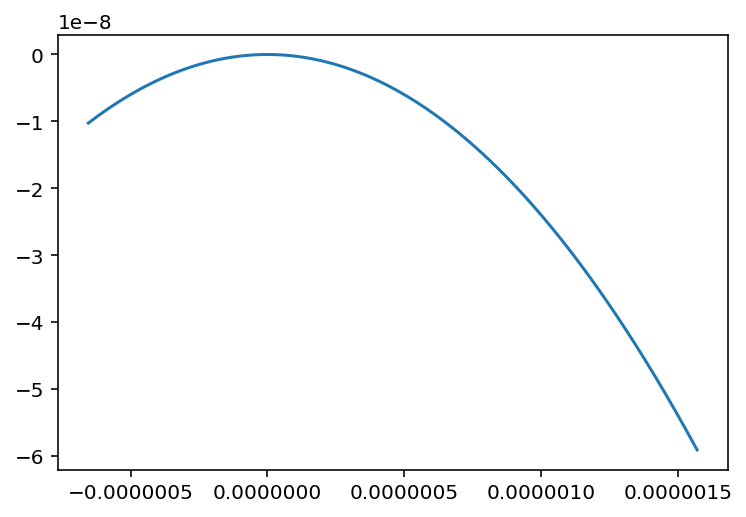

In [9]:
P0 = 1/218.8118405230054218
smin = np.max(psr.toaerrs)
alpha = P0**2/smin**2 
gs = lambda x: 1/np.sqrt(2*np.pi*alpha*smin**2) * np.exp(-x**2/2/alpha/smin**2)
x = np.linspace(psr.residuals.min(), psr.residuals.max(), 1000)
plt.plot(x, gs(x)/gs(x).max() - 1)

In [10]:
P0

0.004570136595943774

In [54]:
#mdls = []
labels = ['vvh17', 'individual', 'uniform', 'beta', 'gaussian', 't']
# emulate Vallisneri and van Haasteren mixture model
# what should alpha be?
gibbs = Gibbs2(pta, model='vvh17', vary_df=False, theta_prior='uniform', 
               vary_alpha=False, alpha=1e10, pspin=0.00457)
mdls.append(gibbs)

#gibbs = Gibbs(pta, model='mixture')
#mdls.append(gibbs)

# uniform theta distribution
gibbs = Gibbs2(pta, model='mixture', vary_df=True, theta_prior='uniform')
mdls.append(gibbs)

# beta theta distribution
gibbs = Gibbs2(pta, model='mixture', vary_df=True, theta_prior='beta')
mdls.append(gibbs)

# Gaussian
gibbs = Gibbs2(pta, model='gaussian', vary_df=True, theta_prior='beta')
mdls.append(gibbs)

# t-distribution
gibbs = Gibbs2(pta, model='t', vary_df=True, theta_prior='beta')
mdls.append(gibbs)


In [55]:
mdls

In [56]:
#for md in mdls[]:
md = mdls[5]
params = np.array([p.sample() for p in md.params]).flatten()
niter = 10000
md.sample(params, niter=niter)
    

Finished 99 percent in 530.672 seconds.

In [43]:
mpars = np.load('/Users/jaellis/Downloads/J1643-1224-pars.npy')

In [44]:
pmap = {'1643-1224_efac': 0, '1643-1224_gamma': 4, 
        '1643-1224_log10_A': 3, '1643-1224_log10_ecorr': 2, 
        '1643-1224_log10_equad': 1}

vvh17 2
vvh172 2


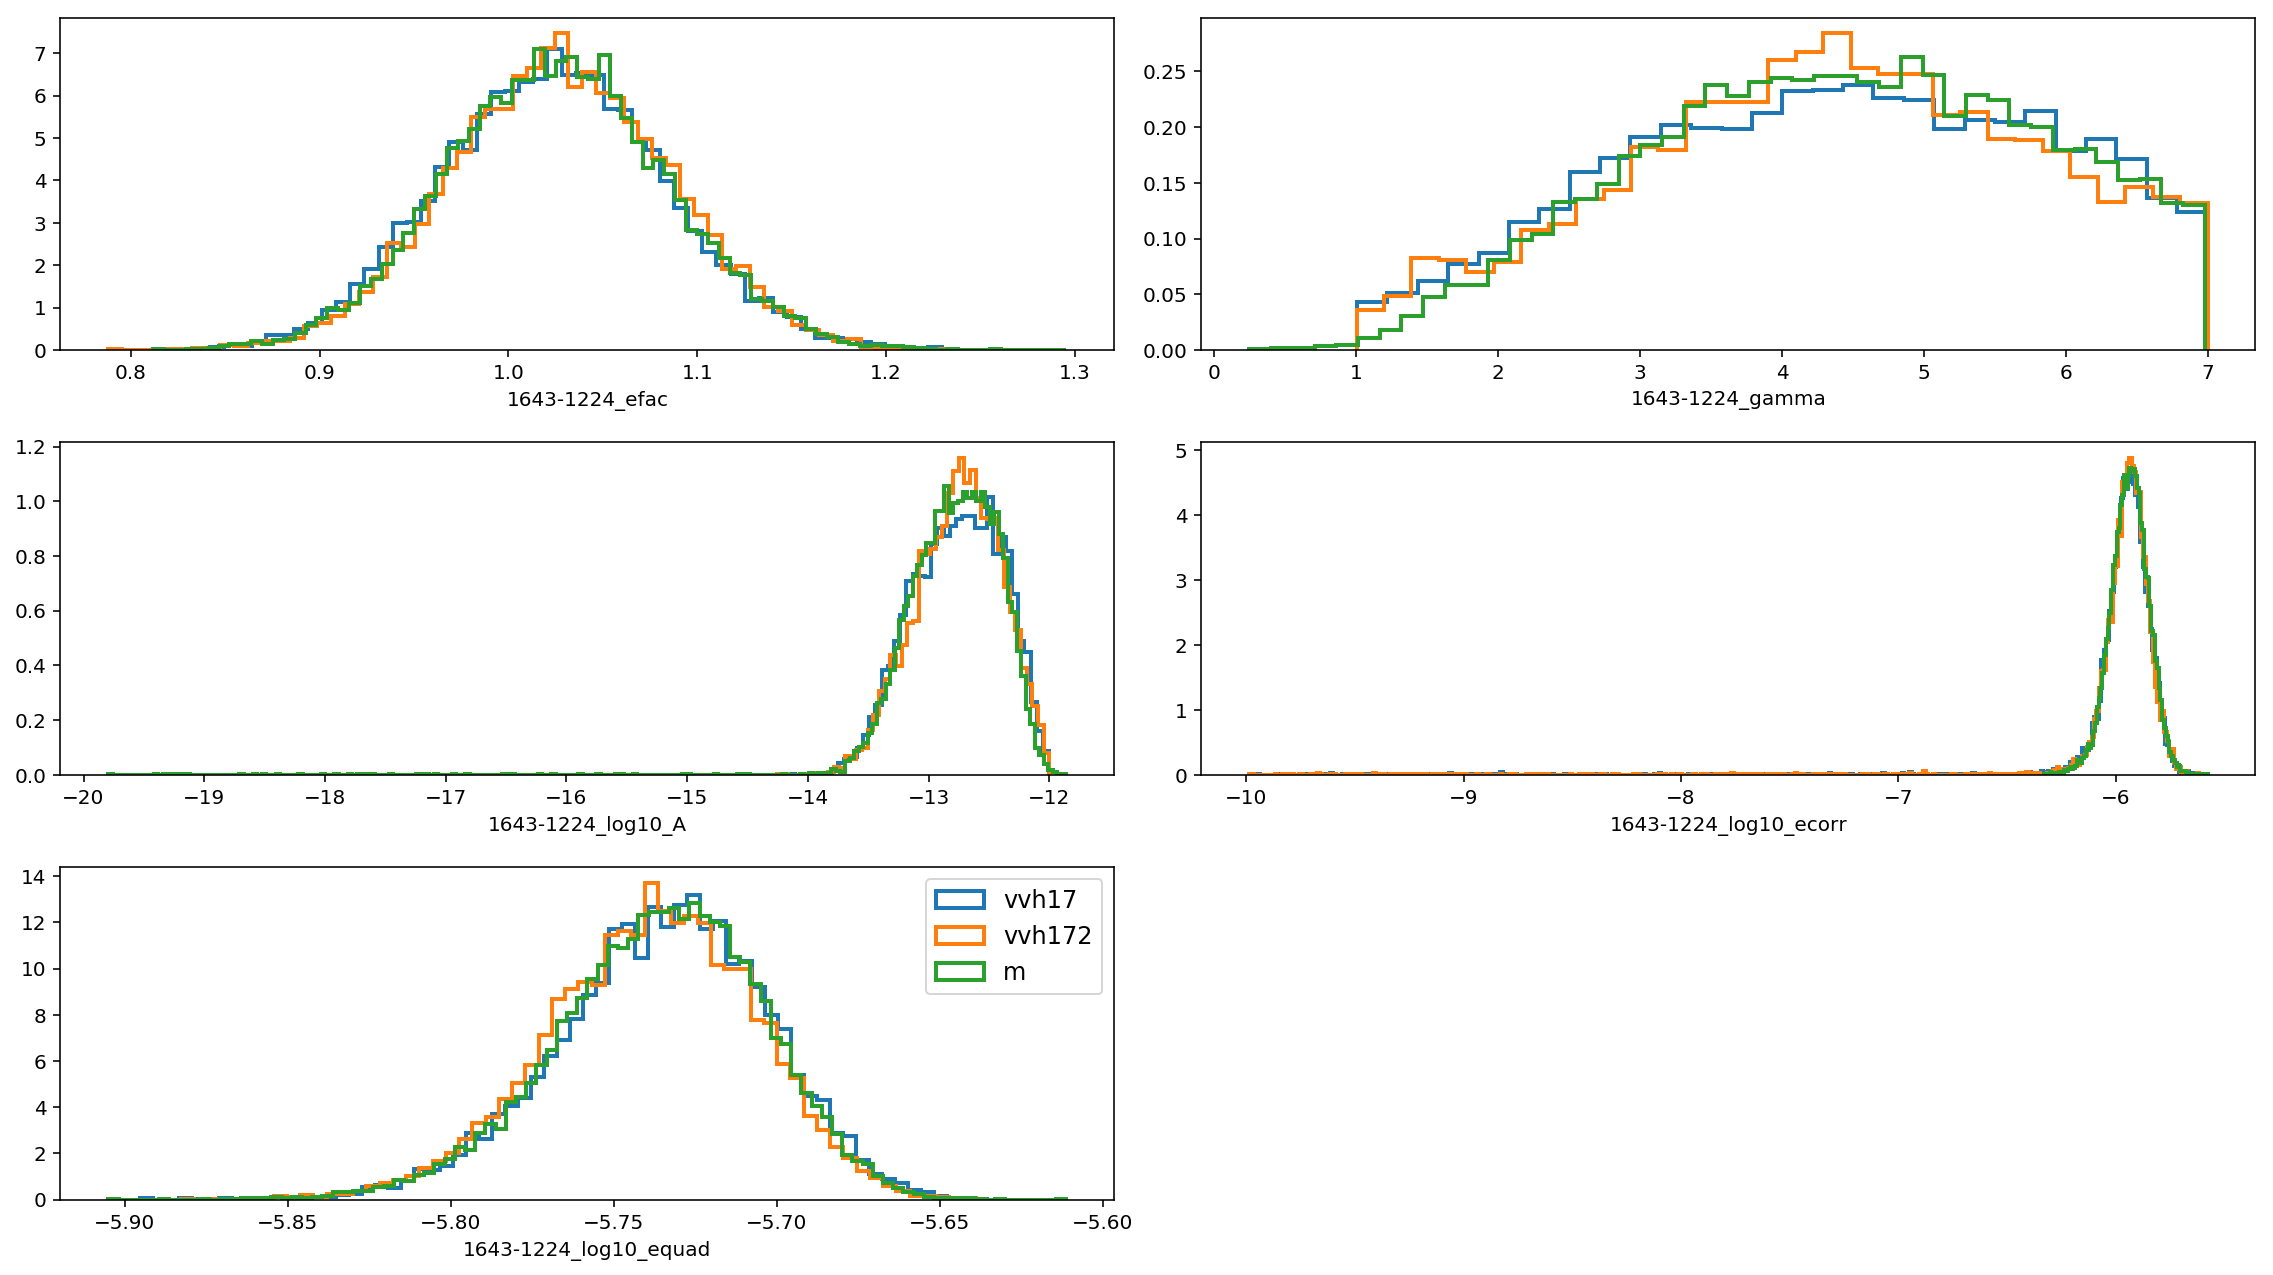

In [58]:
labels = ['vvh17', 'uniform', 'beta', 'gaussian', 't']
labels = ['vvh17', 'vvh172']
plt.figure(figsize=(16,9))
mdls2 = [mdls[0], mdls[5]]
for md, label in zip(mdls2, labels):
    pars = sorted([par.name for par in md.params])
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    print label, len(out)
    for ii in range(5):
        plt.subplot(3,2,ii+1)
        plt.hist(md.chain[300:,ii], bins='auto', normed=True, histtype='step', lw=2, label=label)
        plt.xlabel(pars[ii])
for ii in range(5):
    plt.subplot(3,2,ii+1)
    plt.hist(mpars[:,pmap[pars[ii]]], bins='auto', normed=True, histtype='step', lw=2, label='m')
plt.tight_layout()
plt.legend(loc='best', fontsize=12)

#plt.savefig('hyper_pars_t.pdf', bbox_inches='tight')

vvh17 4
uniform 7
beta 7
gaussian 0
t 130


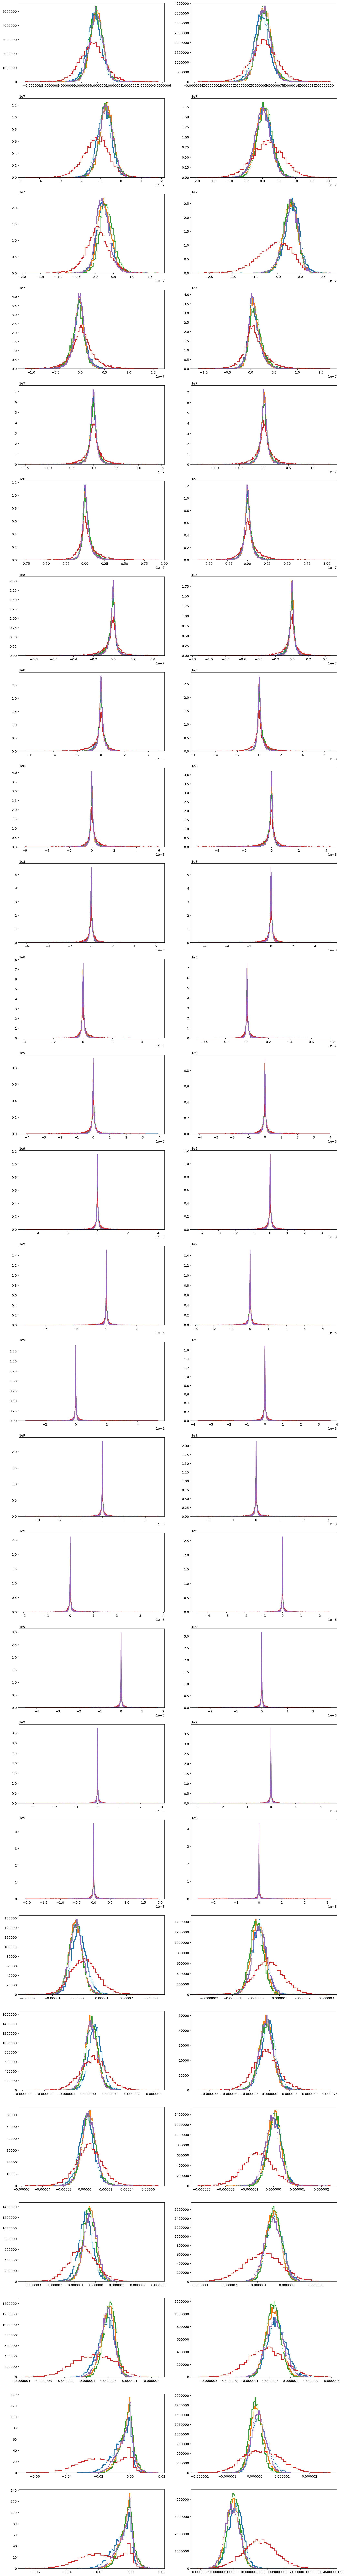

In [20]:
labels = ['vvh17', 'uniform', 'beta', 'gaussian', 't']
plt.figure(figsize=(15,3*37))
for md, label in zip(mdls, labels):
    pars = sorted([par.name for par in md.params])
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    print label, len(out)
    for ii in range(54):
        plt.subplot(27,2,ii+1)
        plt.hist(md.bchain[300:,ii], bins='auto', normed=True, histtype='step', lw=2, label=label)
        #plt.title(pars[ii])
plt.tight_layout()
plt.savefig('b_pars_t.pdf', bbox_inches='tight')

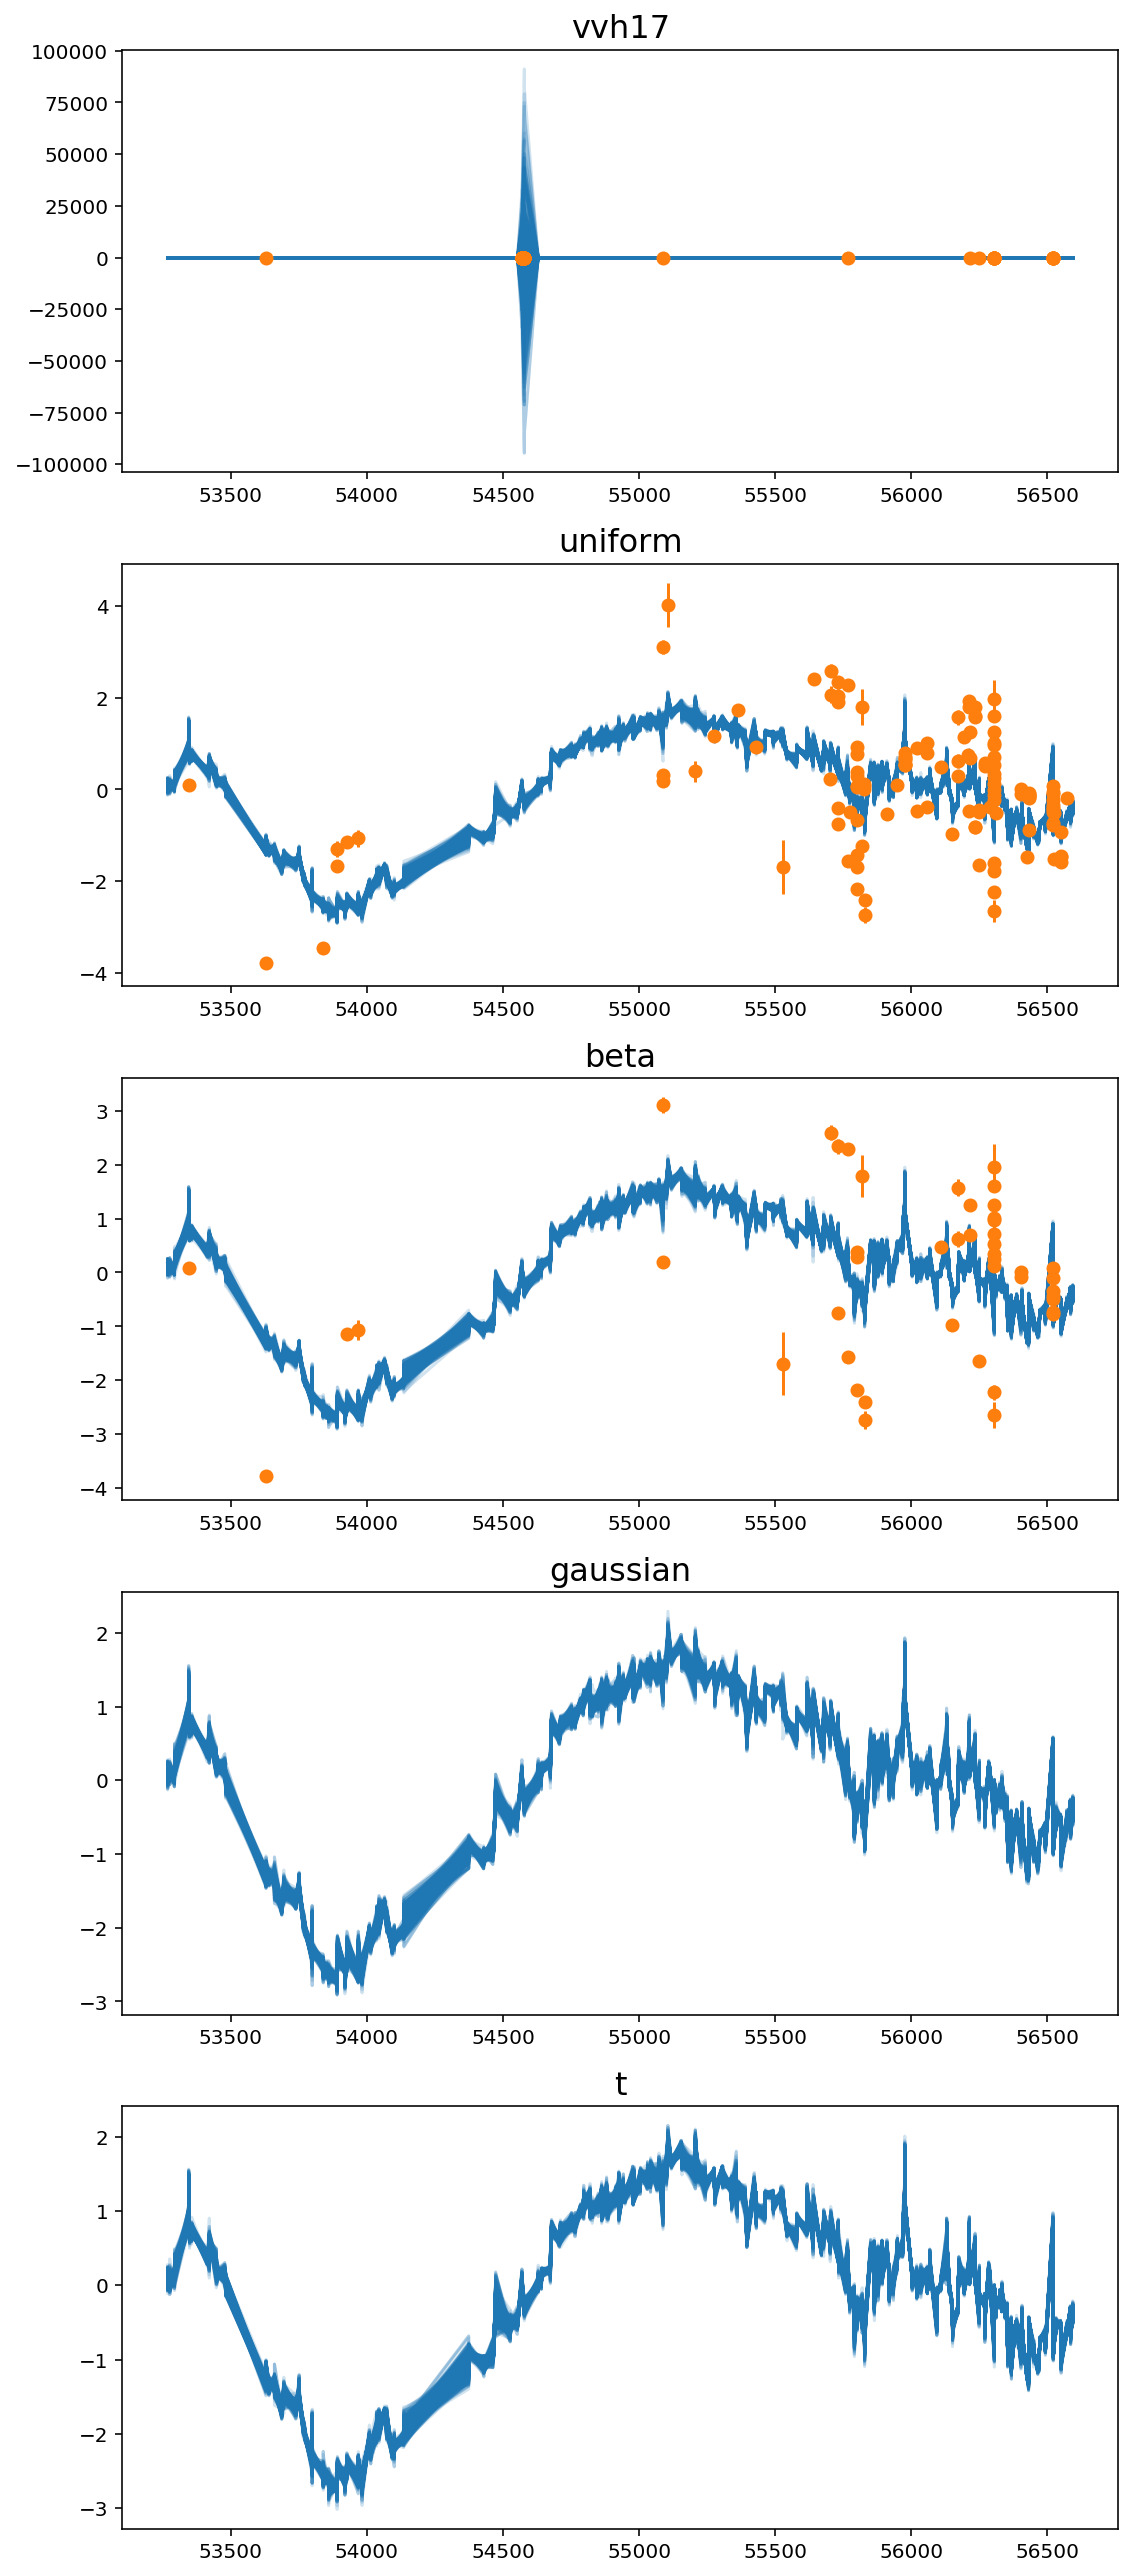

In [33]:
plt.figure(figsize=(8,3*6))
ct = 0
for md, label in zip(mdls, labels):
    plt.subplot(5,1,ct+1)
    Tmat = pta.get_basis()[0]
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    for ii in range(500):
        ind = np.random.randint(100, 10000)
        plt.plot(psr.toas/86400, np.dot(Tmat, md.bchain[ind, :])*1e6, color='C0', alpha=0.2)
    #plt.errorbar(psr.toas/86400, psr.residuals*1e6, psr.toaerrs*1e6, fmt='.', color='k')
    if len(out) < len(psr.toas):
        plt.errorbar(psr.toas[out]/86400, psr.residuals[out]*1e6, psr.toaerrs[out]*1e6, fmt='o', color='C1')
    plt.title(label, fontsize=16)
    ct += 1
plt.tight_layout()
#plt.savefig('waveform_t.pdf', bbox_inches='tight')

In [77]:
out = np.flatnonzero(mdls[1].zchain.mean(axis=0)>0.9)
out

array([  85,  112,  144,  179,  632,  675,  865,  982, 1068, 1243, 1244])

In [78]:
for o in out:
    print np.median(mdls[1].poutchain[500:,o])


0.992780554685
0.999745349484
0.999999993111
0.986752310936
0.999940889096
1.0
0.996061476841
0.999999999999
0.999497044654
0.999501716126
0.981591379719


AttributeError: 'Gibbs2' object has no attribute 'zchain'

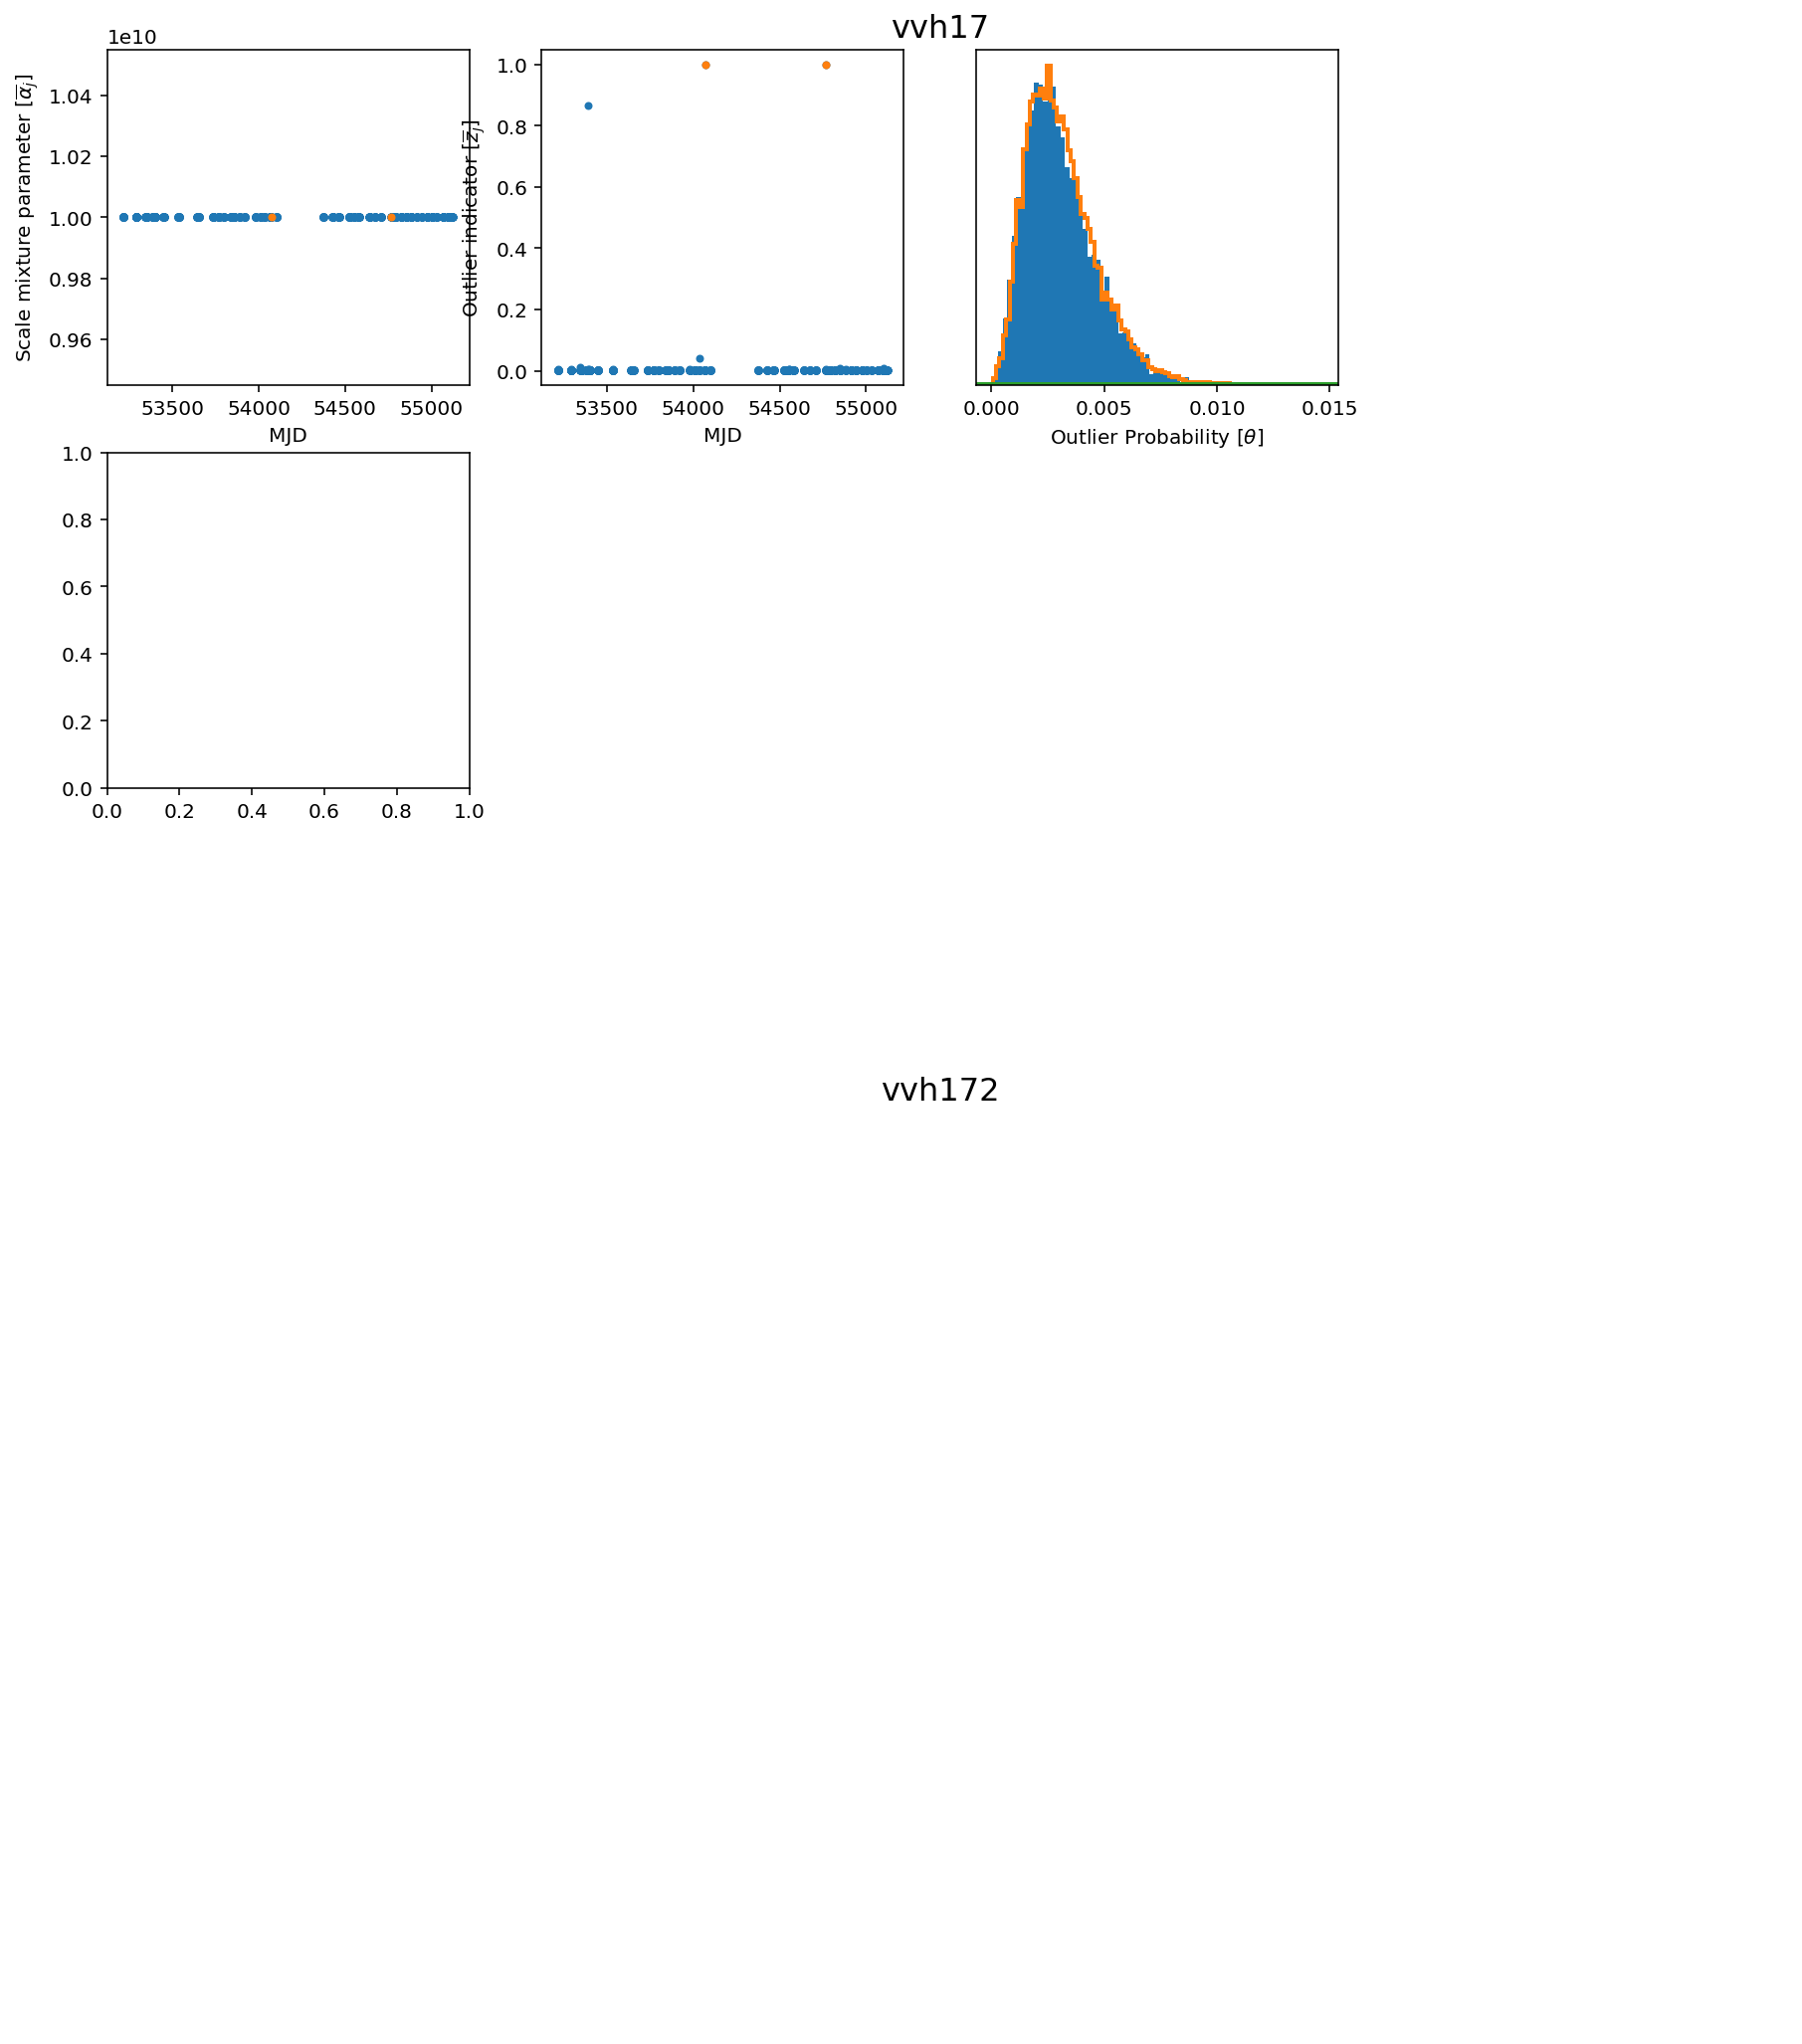

In [59]:
fig, big_axes = plt.subplots( figsize=(15.0, 3*6) , nrows=2, ncols=1, sharey=False) 
labels = ['vvh17', 'vvh172']
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(labels[row-1], fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
ct = 0
for md, label in zip(mdls, labels):
    ax = fig.add_subplot(5,4,4*ct+1)
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    plt.plot(psr.toas/86400, md.alphachain[1000:,:].mean(axis=0), '.')
    plt.plot(psr.toas[out]/86400, md.alphachain[1000:,out].mean(axis=0), '.')
    plt.ylabel(r'Scale mixture parameter [$\overline{\alpha}_j$]')
    plt.xlabel(r'MJD')
    
    ax = fig.add_subplot(5,4,4*ct+2)
    plt.plot(psr.toas/86400, md.zchain.mean(axis=0), '.')
    #plt.plot(psr.toas/86400, np.median(md.poutchain, axis=0), '.')
    plt.plot(psr.toas[out]/86400, md.zchain.mean(axis=0)[out], '.')
    plt.ylabel(r'Outlier indicator [$\overline{z}_j$]')
    plt.xlabel(r'MJD')
    
    if label in ['vvh17', 'uniform', 'beta']:
        ax = fig.add_subplot(5,4,4*ct+3)
        plt.hist(md.thetachain[1000:], bins='auto', normed=True);
        if label == 'beta':
            k = len(psr.residuals)
            m = 0.01
            y = scipy.stats.beta(k*m, k*(1-m))
            x = np.linspace(0.0, md.thetachain[1000:].max(), 1000)
            plt.plot(x, y.pdf(x), lw=2, color='C2')
        else:
            plt.axhline(1, lw=2, color='C2')
        ax.get_yaxis().set_visible(False)
        plt.xlabel(r'Outlier Probability [$\theta$]')
        if label == 'vvh17':
            plt.hist(mpars[:,5], bins='auto', normed=True, histtype='step', lw=2, color='C1')
     
    if label in ['uniform', 'beta', 't']:
        ax = fig.add_subplot(5,4,4*ct+4)
        dfs = np.unique(md.dfchain[1000:])
        counts = np.array([sum(md.dfchain[1000:]==df) for df in dfs])
        plt.bar(dfs, counts, align='center')
        ax.get_yaxis().set_visible(False)
        plt.xlabel('t-disribution d.o.f')
    ct += 1
plt.tight_layout()
#plt.savefig('outlier_pars_t.pdf', bbox_inches='tight')

plt.plot(mdls[1].thetachain[100:])

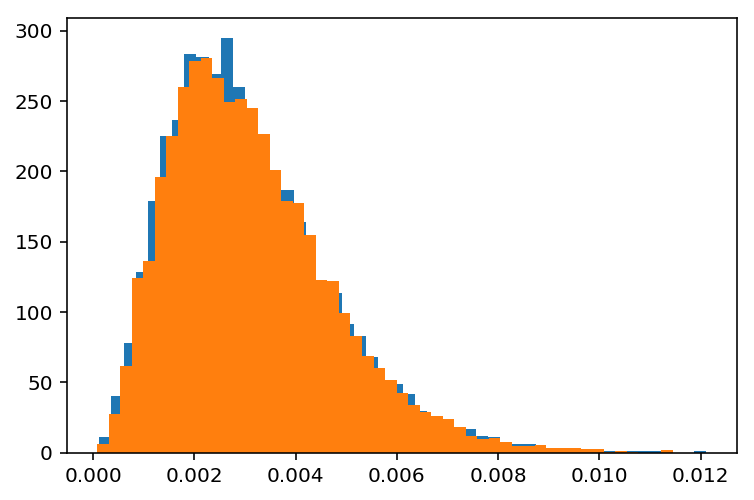

In [67]:
plt.hist(mdls[0].thetachain[100:], 50, normed=True);
plt.hist(mdls[5].thetachain[100:], 50, normed=True);

In [64]:
mdls